In [1]:
# Common imports
import pandas as pd
import numpy as np
import os
import seaborn as sns
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
import joblib

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images",)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shubham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Load data

In [2]:
def load_data():
    data = pd.read_csv('spill_incidents_sample.csv')
    return data

#### Create target variable
- The dataset has a column “recovered”. Recovered can be greater than 0(YES) or equals to 0 (NO).

In [3]:
def transform_target(df):
    df['recovered'] = df['recovered'].apply(lambda x:1 if x >0 else 0)
    return df

data = load_data()
data = transform_target(data)
data.drop('Unnamed: 0', axis=1, inplace=True)
data.to_csv('spill_incidents_sample_with_target.csv', index=False)


#### Data overview

In [4]:
data.tail(3)

,spill_number,program_facility_name,street_1,street_2,locality,county,zip_code,swis_code,dec_region,spill_date,received_date,contributing_factor,waterbody,source,close_date,material_name,material_family,quantity,units,recovered
187666,9707739,KIKARI DENTAL RT 30 AGWAY,4340 RT 30 NORTH,NaN,AMSTERDAM,Montgomery,NaN,2920,4,1997-09-30,1997-09-30,Tank Overfill,NaN,Tank Truck,1997-10-03,#2 fuel oil,Petroleum,0.0,Gallons,0
187667,1209420,POLE TOP,29 QUARRY LANE,NaN,BEDFORD,Westchester,NaN,6020,3,2012-11-06,2012-11-06,Storm,NaN,Transformer,2012-11-09,dielectric fluid,Petroleum,10.0,Gallons,0
187668,900797,CUMBERLAND FARMS #3141 RT 9 @ BOGHT RD LOUDON RD,1093 LOUDON RD RT 9 @ BOGHT RD,CUMBERLAND FARMS # 3141 1093 LOUDON RD,COHOES COLONIE,Albany,NaN,126,4,2009-04-21,2009-04-21,Other,NaN,Gasoline Station or other PBS Facility,2009-05-08,other - WATER,Other,0.0,Gallons,0


In [5]:
data.recovered = data.recovered.astype('category')

In [6]:
data.describe()

,spill_number,swis_code,dec_region,quantity
count,1.876690e+05,187669.000000,187669.000000,1.876690e+05
mean,4.442654e+06,3478.814391,3.992956,5.350332e+05
std,4.208655e+06,1717.484381,2.593400,2.308367e+08
min,1.000000e+00,100.000000,1.000000,0.000000e+00
25%,7.069440e+05,2401.000000,2.000000,0.000000e+00
50%,1.511169e+06,3400.000000,3.000000,0.000000e+00
75%,9.211040e+06,5200.000000,6.000000,5.000000e+00
max,9.975754e+06,9500.000000,9.000000,1.000000e+11


In [7]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ['Number of Columns','Number of Rows', 'File Size']
x.add_row([data.shape[1], data.shape[0], os.path.getsize('spill_incidents_sample.csv')])
print(x)

+-------------------+----------------+-----------+
| Number of Columns | Number of Rows | File Size |
+-------------------+----------------+-----------+
|         20        |     187669     |  35570195 |
+-------------------+----------------+-----------+


#### Column Type Counts

In [8]:
from dateutil.parser import parse

def check_is_categorical(df, col):
    unique_samples = len(df[col].unique())
    total_samples = df[col].shape[0]
    pct_diff = round((total_samples - unique_samples) / total_samples * 100,2)
#     print(pct_diff)
    if pct_diff <= 94:
        return [False,col] # not categorical
    else:
        return [True, col]  # categorical
    
def check_is_date(df, col):
    string = df[col].dropna().unique()[0]
    try: 
        parse(string, fuzzy=False)
        return [True, col]

    except ValueError:
        return [False, col]
    
    
def get_column_type(df):
    categorical_features = []
    text_features = []
    numeric = list(data.select_dtypes(['int64','float64']).columns)
    types = {'Numeric':[len(data.select_dtypes(['int64','float64']).count()), numeric],\
             'Text':[0,[]],'Categorical':[0,[]], 'Date':[0,[]]}

    for col in df.columns:
        sample = df[col].dropna().unique()[0]
        if isinstance(sample, str):
            res = check_is_date(df, col)
            if res[0]:
                types['Date'][0] +=1
                types['Date'][1].append(col)
            else:
                res = check_is_categorical(df, col)
                if res[0]:
                    types['Categorical'][0] += 1
                    types['Categorical'][1].append(col)
                    categorical_features.append(col)
                else:
                    types['Text'][0] += 1
                    types['Text'][1].append(col)
                    text_features.append(col)
    return types, numeric, categorical_features, text_features


x = PrettyTable()

column_type_count, numerical_features, categorical_features, text_features = get_column_type(data)
x.field_names = ['Feature type', 'Count', 'Feature Name']
x._max_width = {"Feature type":3, "Count":3,"Feature Name":90}
for k,v in column_type_count.items():
    x.add_row([k,v[0],v[1]])
print(x)

+--------------+-------+--------------------------------------------------------------------------------------------+
| Feature type | Count |                                        Feature Name                                        |
+--------------+-------+--------------------------------------------------------------------------------------------+
|   Numeric    |   4   |                  ['spill_number', 'swis_code', 'dec_region', 'quantity']                   |
|     Text     |   3   |                     ['program_facility_name', 'street_1', 'street_2']                      |
| Categorical  |   9   |      ['locality', 'county', 'zip_code', 'contributing_factor', 'waterbody', 'source',      |
|              |       |                        'material_name', 'material_family', 'units']                        |
|     Date     |   3   |                       ['spill_date', 'received_date', 'close_date']                        |
+--------------+-------+--------------------------------

### Data completeness

In [9]:
def calc_data_nullity(df):
    df_nullity = df.isnull()
    missing_values_sum = df_nullity.sum()
    missing_values_percent = df_nullity.mean() * 100
    return missing_values_sum, missing_values_percent

missing_values_sum, missing_values_percent = calc_data_nullity(data)


#### Total Missing Values

In [10]:
x = PrettyTable()
print('Total Missing Values')
x.field_names = ['Column', 'Missing values Count']      
for k,v in missing_values_sum.to_dict().items():
    x.add_row([k,v])
print(x)              

Total Missing Values
+-----------------------+----------------------+
|         Column        | Missing values Count |
+-----------------------+----------------------+
|      spill_number     |          0           |
| program_facility_name |          3           |
|        street_1       |          53          |
|        street_2       |        172775        |
|        locality       |         389          |
|         county        |          0           |
|        zip_code       |        171173        |
|       swis_code       |          0           |
|       dec_region      |          0           |
|       spill_date      |          57          |
|     received_date     |          0           |
|  contributing_factor  |          0           |
|       waterbody       |        170995        |
|         source        |          0           |
|       close_date      |         4302         |
|     material_name     |          0           |
|    material_family    |          0           |

#### Percentage of Missing Values

In [11]:
x = PrettyTable()
print('Total Missing Values')
x.field_names = ['Column', 'Missing values Percentage']      
for k,v in missing_values_percent.to_dict().items():
    x.add_row([k,round(v,2)])
print(x)              

Total Missing Values
+-----------------------+---------------------------+
|         Column        | Missing values Percentage |
+-----------------------+---------------------------+
|      spill_number     |            0.0            |
| program_facility_name |            0.0            |
|        street_1       |            0.03           |
|        street_2       |           92.06           |
|        locality       |            0.21           |
|         county        |            0.0            |
|        zip_code       |           91.21           |
|       swis_code       |            0.0            |
|       dec_region      |            0.0            |
|       spill_date      |            0.03           |
|     received_date     |            0.0            |
|  contributing_factor  |            0.0            |
|       waterbody       |           91.12           |
|         source        |            0.0            |
|       close_date      |            2.29           |
|     m

- Columns **`street_2, zip_code, waterbody`** have the highest number of missing values
- Since more than 90% values are missing, its better to drop these columns

#### Visualize missingness

<AxesSubplot:>

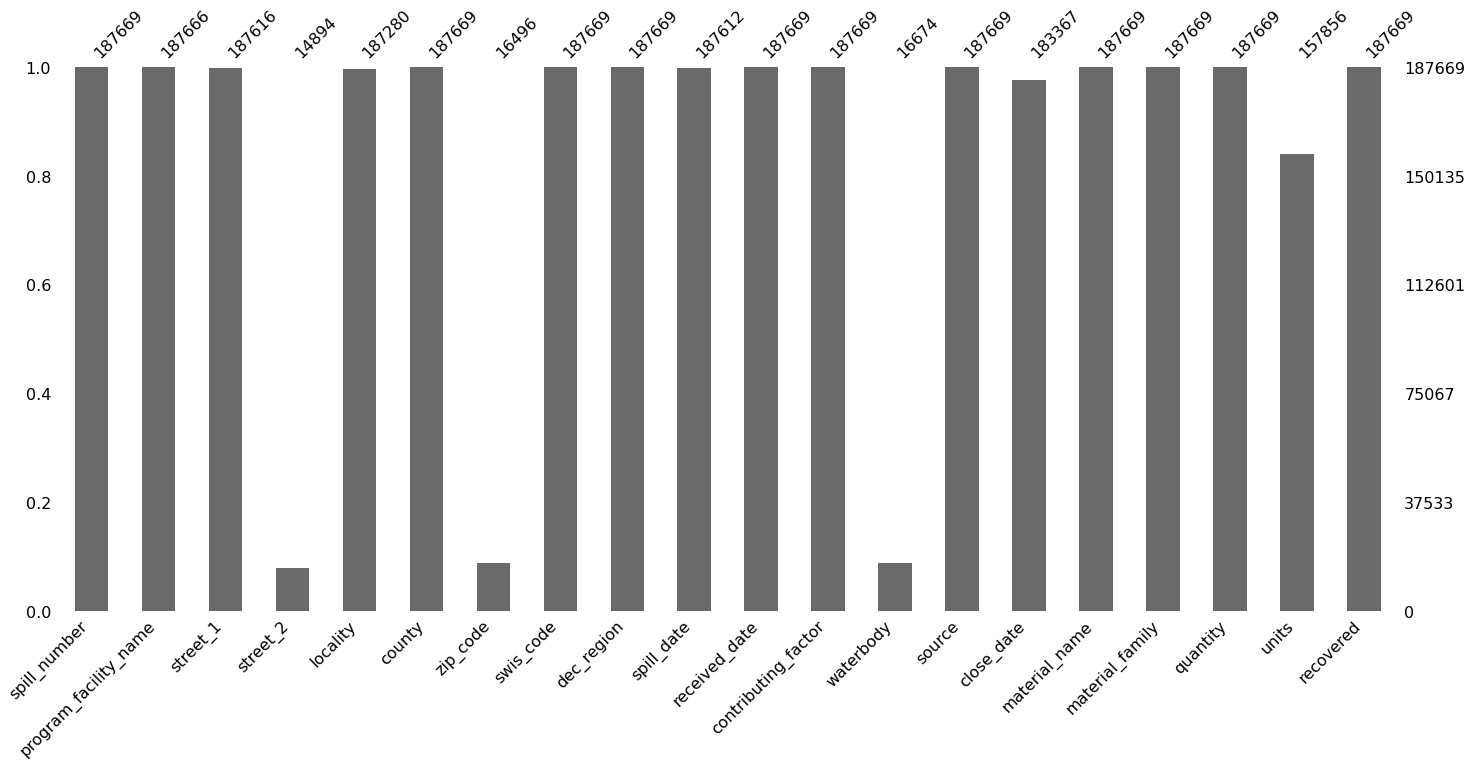

In [12]:
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline

# Plot amount of missingness
msno.bar(data)

#### Drop columns with  >90% missing values **`street_2, zip_code, waterbody`**

In [13]:
data_dropped_missing = data.drop(['street_2', 'zip_code', 'waterbody'], axis=1)
data_dropped_missing.tail(2)

,spill_number,program_facility_name,street_1,locality,county,swis_code,dec_region,spill_date,received_date,contributing_factor,source,close_date,material_name,material_family,quantity,units,recovered
187667,1209420,POLE TOP,29 QUARRY LANE,BEDFORD,Westchester,6020,3,2012-11-06,2012-11-06,Storm,Transformer,2012-11-09,dielectric fluid,Petroleum,10.0,Gallons,0
187668,900797,CUMBERLAND FARMS #3141 RT 9 @ BOGHT RD LOUDON RD,1093 LOUDON RD RT 9 @ BOGHT RD,COHOES COLONIE,Albany,126,4,2009-04-21,2009-04-21,Other,Gasoline Station or other PBS Facility,2009-05-08,other - WATER,Other,0.0,Gallons,0


# Check for Anomalies in Dates data

##### 1. Logically `close_date` should not be less than `received_date` or `spill_date`

In [14]:
data_dropped_validate = data_dropped_missing.copy()
data_dropped_validate.close_date = pd.to_datetime(data_dropped_validate.close_date)
data_dropped_validate.received_date = pd.to_datetime(data_dropped_validate.received_date)
data_dropped_validate.spill_date = pd.to_datetime(data_dropped_validate.spill_date)

## get indices where close date less than received date
anomaly_indexes = data_dropped_validate[data_dropped_validate['close_date'] < data_dropped_validate['received_date']].index
data_dropped_missing = data_dropped_missing.drop(anomaly_indexes)
data_dropped_missing.shape

(186701, 17)

## Treat missing values
### Details of missing numbers

In [15]:
data_dropped_missing.isna().sum()

spill_number                 0
program_facility_name        3
street_1                    53
locality                   285
county                       0
swis_code                    0
dec_region                   0
spill_date                  57
received_date                0
contributing_factor          0
source                       0
close_date                4302
material_name                0
material_family              0
quantity                     0
units                    29684
recovered                    0
dtype: int64

### Below are  imputation strategies 
##### 1. Impute `program_facility_name` with `contributing factor `
##### 2. Impute `street_1` with `country `
##### 3. Impute `locality` with `country `
##### 4. Impute `spill_date` with `received_date`
##### 5. Impute `close_date` with `spill_date`
##### 6. Impute `units` with `pounds`
- On analysis found that most of the quantity values are 0 for missing `units`

In [16]:
# Impute `program_facility_name` with `contributing factor`
data_dropped_missing.loc[data_dropped_missing['program_facility_name'].isnull(),'program_facility_name'] = data_dropped_missing['contributing_factor']

# Impute `street_1` with `country`
data_dropped_missing.loc[data_dropped_missing['street_1'].isnull(),'street_1'] = data_dropped_missing['county']

# Impute `locality` with `country`
data_dropped_missing.loc[data_dropped_missing['locality'].isnull(),'locality'] = data_dropped_missing['county']

# Impute `spill_date` with `received_date`
data_dropped_missing.loc[data_dropped_missing['spill_date'].isnull(),'spill_date'] = data_dropped_missing['received_date']

# Impute `close_date` with `spill_date`
data_dropped_missing.loc[data_dropped_missing['close_date'].isnull(),'close_date'] = data_dropped_missing['spill_date']

# Impute `units` with `pounds`
data_dropped_missing.loc[data_dropped_missing['units'].isnull(),'units'] = 'Pounds'

#### Check for null values after imputation

In [17]:
data_dropped_missing.isna().sum()

spill_number             0
program_facility_name    0
street_1                 0
locality                 0
county                   0
swis_code                0
dec_region               0
spill_date               0
received_date            0
contributing_factor      0
source                   0
close_date               0
material_name            0
material_family          0
quantity                 0
units                    0
recovered                0
dtype: int64

#### Preprocess text features

In [18]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(x):
    d = ["".join(word) for word in x.split() if word not in stop_words]
    return d

data_dropped_missing['program_facility_name'] = data_dropped_missing['program_facility_name'].apply(lambda x:re.sub('[^a-zA-Z0-9\n]', ' ', x))
data_dropped_missing['program_facility_name'] = data_dropped_missing['program_facility_name'].apply(lambda x:re.sub('\s+',' ', x))
data_dropped_missing['program_facility_name'] = data_dropped_missing['program_facility_name'].apply(lambda x:x.lower())
data_dropped_missing['program_facility_name'] = data_dropped_missing['program_facility_name'].apply(lambda x:' '.join(list(map(remove_stopwords, [x]))[0]))

data_dropped_missing['street_1'] = data_dropped_missing['street_1'].apply(lambda x:re.sub('[^a-zA-Z0-9\n]', ' ', x))
data_dropped_missing['street_1'] = data_dropped_missing['street_1'].apply(lambda x:re.sub('\s+',' ', x))
data_dropped_missing['street_1'] = data_dropped_missing['street_1'].apply(lambda x:x.lower())
data_dropped_missing['street_1'] = data_dropped_missing['street_1'].apply(lambda x:' '.join(list(map(remove_stopwords, [x]))[0]))

#### Check for class imbalance if any

In [19]:
data_dropped_missing['recovered'].value_counts()

0    164581
1     22120
Name: recovered, dtype: int64

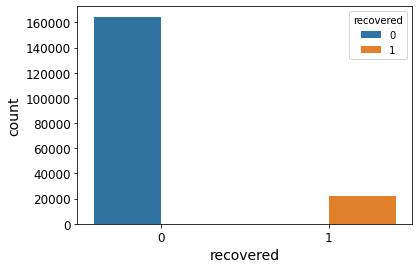

In [20]:
ax = sns.countplot(x="recovered", hue="recovered", data=data_dropped_missing)

- There is a class imbalance in the target varaible

Saving figure attribute_histogram_plots


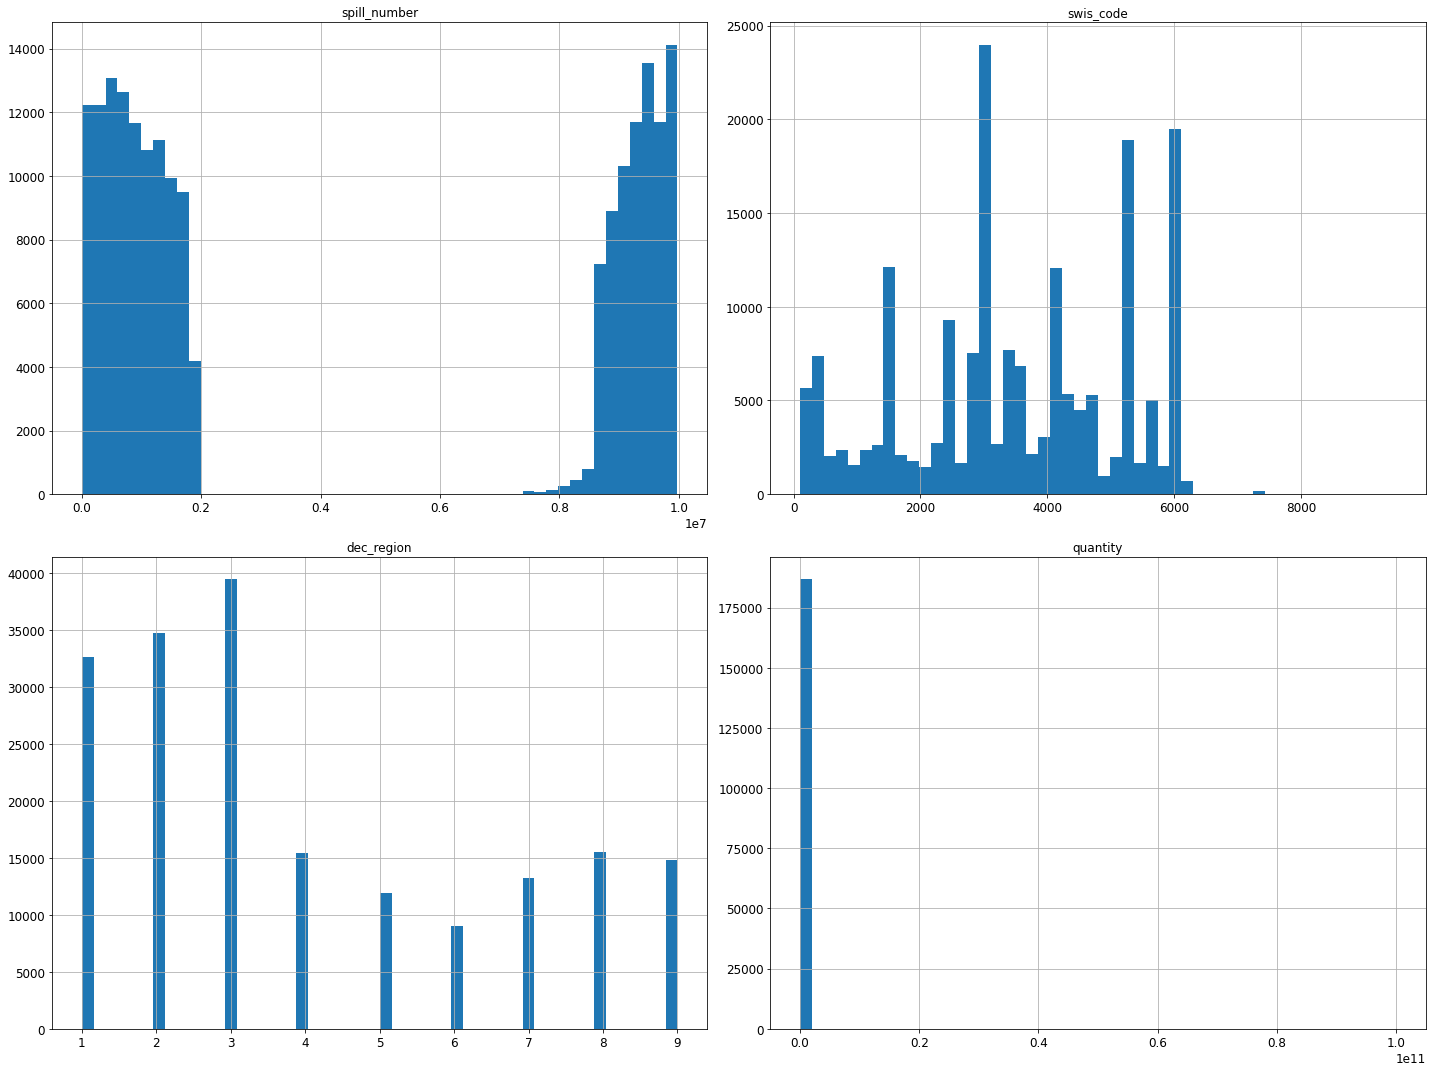

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
data_dropped_missing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [22]:
# to make this notebook's output identical at every run
np.random.seed(42)

#### Check correlations

In [23]:
corr_matrix = data_dropped_missing.corr()
corr_matrix

,spill_number,swis_code,dec_region,quantity
spill_number,1.000000,-0.058086,0.044208,-0.001498
swis_code,-0.058086,1.000000,-0.302013,-0.004517
dec_region,0.044208,-0.302013,1.000000,0.000008
quantity,-0.001498,-0.004517,0.000008,1.000000


Saving figure scatter_matrix_plot


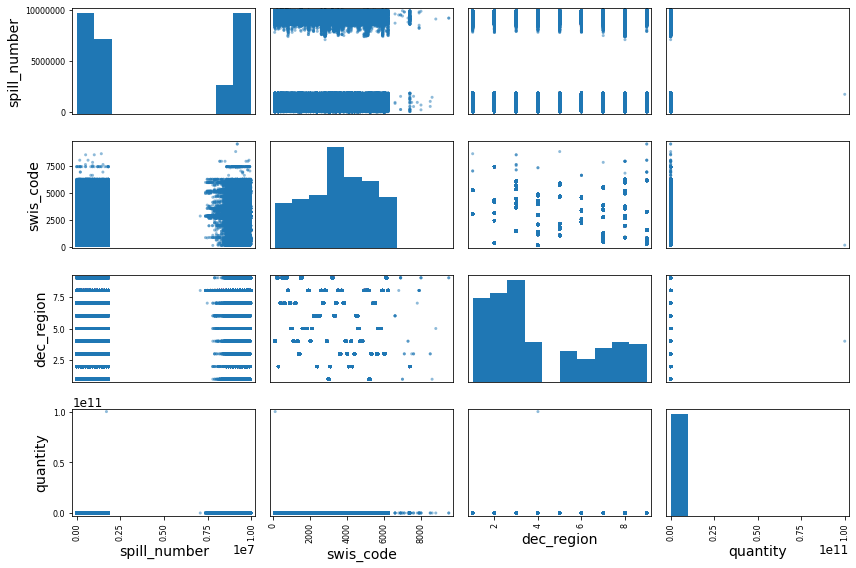

In [24]:
from pandas.plotting import scatter_matrix


scatter_matrix(data_dropped_missing[numerical_features], figsize=(12, 8))
save_fig("scatter_matrix_plot")

## Feature Engineering / Transformations

### Feature binning : `quantity`
#### Since `quantity` , `contributing_factor`, `program_facility_name` are important features , ensure its distributed properly in the test set. Since `quantity` is a continuos feature, so create its categories first

#### Quantity spilled Unique values 

In [25]:
data_dropped_missing['quantity'].sort_values().apply("{0:.5f}".format).unique()

array(['0.00000', '0.01000', '0.02000', '0.03000', '0.04000', '0.05000',
       '0.06000', '0.07000', '0.08000', '0.09000', '0.10000', '0.12000',
       '0.13000', '0.14000', '0.15000', '0.16000', '0.17000', '0.18000',
       '0.19000', '0.20000', '0.25000', '0.26000', '0.30000', '0.31000',
       '0.32000', '0.33000', '0.36000', '0.37000', '0.38000', '0.40000',
       '0.45000', '0.49000', '0.50000', '0.60000', '0.63000', '0.70000',
       '0.75000', '0.78000', '0.80000', '0.90000', '0.99000', '1.00000',
       '1.01000', '1.10000', '1.20000', '1.23000', '1.25000', '1.40000',
       '1.50000', '1.60000', '1.70000', '1.75000', '1.80000', '1.90000',
       '2.00000', '2.10000', '2.20000', '2.25000', '2.30000', '2.40000',
       '2.50000', '2.58000', '2.75000', '2.78000', '2.80000', '2.90000',
       '3.00000', '3.13000', '3.50000', '3.59000', '3.60000', '3.70000',
       '3.80000', '3.90000', '4.00000', '4.13000', '4.20000', '4.40000',
       '4.50000', '4.60000', '4.70000', '4.80000', 

In [26]:
# data_dropped_missing["quantity_cat"] = pd.cut(data_dropped_missing["qunatity"],
#                                bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
#                                labels=[1, 2, 3, 4, 5])

# Divide by 1.5 to limit the number of income categories
data_dropped_missing["quantity_cat"] = np.ceil(data_dropped_missing["quantity"] / 1.5)
# Label those above 5 as 5
data_dropped_missing["quantity_cat"].where(data_dropped_missing["quantity_cat"] < 3, 3.0, inplace=True)


In [27]:
data_dropped_missing['quantity_cat'].value_counts()

0.0    99676
3.0    56340
1.0    19926
2.0    10759
Name: quantity_cat, dtype: int64

<AxesSubplot:>

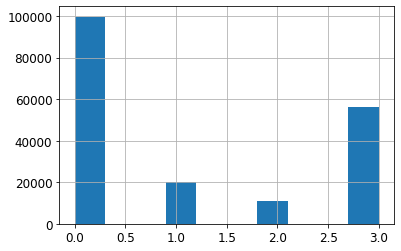

In [28]:
data_dropped_missing["quantity_cat"].hist()

### Featurize Date Columns

##### 1. Split date columns intto year, month , day

In [29]:
data_dropped_missing[["close_year", "close_month", "close_day"]] = data_dropped_missing["close_date"].str.split("-", expand = True)
data_dropped_missing[["received_year", "received_month", "received_day"]] = data_dropped_missing["received_date"].str.split("-", expand = True)
data_dropped_missing[["spill_year", "spill_month", "spill_day"]] = data_dropped_missing["spill_date"].str.split("-", expand = True)

#### Drop close_date, spill_date, received_date

In [30]:
data_dropped_missing = data_dropped_missing.drop(['close_date', 'received_date', 'spill_date'], axis=1)

In [31]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data_dropped_missing, data_dropped_missing[["quantity_cat", "contributing_factor",'recovered']]):
    strat_train = data_dropped_missing.reindex(train_index)
    strat_test_set = data_dropped_missing.reindex(test_index)

#### Drop nans    ##
sample_incomplete_rows_indexes = strat_train[strat_train.isnull().any(axis=1)].index #.head()
strat_train = strat_train.drop(sample_incomplete_rows_indexes)
    
for train_index, test_index in split.split(strat_train, strat_train[["quantity_cat", "contributing_factor",'recovered']]):
    strat_train_set = strat_train.reindex(train_index)
    strat_val_set = strat_train.reindex(test_index)    

# Prepare the data for Machine Learning algorithms

In [32]:
X_train = strat_train_set.drop("recovered", axis=1) # drop labels for training set
y_train = strat_train_set["recovered"].copy()

X_val = strat_val_set.drop("recovered", axis=1) # drop labels for validation set
y_val = strat_val_set["recovered"].copy()

X_test = strat_test_set.drop("recovered", axis=1) # drop labels for validation set
y_test = strat_test_set["recovered"].copy()

In [33]:
## find and drop null values
sample_incomplete_rows_indexes = X_train[X_train.isnull().any(axis=1)].index #.head()
X_train = X_train.drop(sample_incomplete_rows_indexes)
y_train = y_train.drop(sample_incomplete_rows_indexes)
# spill_data.tail()

sample_incomplete_rows_indexes = X_val[X_val.isnull().any(axis=1)].index #.head()
X_val = X_val.drop(sample_incomplete_rows_indexes)
y_val = y_val.drop(sample_incomplete_rows_indexes)

sample_incomplete_rows_indexes = X_test[X_test.isnull().any(axis=1)].index #.head()
X_test = X_test.drop(sample_incomplete_rows_indexes)
y_test = y_test.drop(sample_incomplete_rows_indexes)

In [34]:
print('X_train :', X_train.shape)
print('X_test  :', X_test.shape)
print('X_val   :', X_val.shape)

X_train : (94739, 23)
X_test  : (37135, 23)
X_val   : (23612, 23)


#### Encoding categorical variables

#### `DataFrameSelector` transforms the data by selecting the desired attributes, dropping the rest, and converting the resulting DataFrame to a Numpy array

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

###     The Pipeline module wraps an entire workflow in a single object.

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

try:
    numerical_features.extend(["close_year", "close_month", "close_day", "received_year", "received_month", "received_day",\
                              "spill_year", "spill_month", "spill_day"])
    numerical_features.remove('quantity')
    categorical_features.remove('zip_code')
    categorical_features.remove('waterbody')
    categorical_features.remove('recovered')
    text_features.remove('street_2')
except:
    pass
categorical_features_ordinal = ['quantity_cat']

In [37]:
############# Transformation Pipeline for numerical features ###########
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(numerical_features)),
        ('std_scaler', StandardScaler()),
    ])

In [38]:
############ Transformation pipeline for Ordinal categorical features ##########
ord_cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(categorical_features_ordinal)),
        ('ord_cat_encoder', OrdinalEncoder(handle_unknown="ignore")),
    ])

In [39]:
############ Transformation pipeline for remaining categorical features ##########
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(categorical_features)),
        ('ohe_cat_encoder', OneHotEncoder(handle_unknown="ignore",sparse=False)),
    ])

In [40]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer


############ Transformation pipeline for text features (program_facility_name) ##########

text_pipeline_f1 = Pipeline([('selector', DataFrameSelector("program_facility_name")),
                             ('count_1', CountVectorizer(binary=True, min_df=10)),
                  ('tfid_1', TfidfTransformer(use_idf=True))])


text_pipeline_f2 = Pipeline([('selector', DataFrameSelector("street_1")),
                            ('count_2', CountVectorizer(binary=True,min_df=10)),
                  ('tfid_2', TfidfTransformer(use_idf=True))])


### Combining above pipelines into single pipeline using `FeatureUnion`

##### Give it a list of transformer pipelines, when it's transform() method is called it runs each transformers transform method in parallel, waits for their output, and then concatenates them and returns the result

In [41]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
        ("ord_cat_pipeline" ,ord_cat_pipeline),
        ("text_pipeline_f1", text_pipeline_f1),
        ("text_pipeline_f2", text_pipeline_f2)
    ])

# save the model to disk
filename = 'full_pipeline.pkl'
joblib.dump(full_pipeline, filename)

['full_pipeline.pkl']

#### Fit and transform the features

In [42]:
X_train_tr = full_pipeline.fit_transform(X_train)

In [43]:
print(X_train_tr.shape)
print(y_train.shape)

(94739, 11738)
(94739,)


#### Training classifier

In [44]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train_tr, y_train)
# log_reg.fit(spill_data_prepared, spill_labels)

SGDClassifier(max_iter=5, random_state=42, tol=-inf)

In [45]:
# let's try the full preprocessing pipeline on a few training instances
some_data = X_train.iloc[:5]
some_labels = y_train.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", sgd_clf.predict(some_data_prepared))

Predictions: [0 0 0 0 0]


#### Cross validation

In [46]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train_tr, y_train, cv=3, scoring="accuracy")

array([0.87583914, 0.86931602, 0.87843187])

In [47]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train_tr, y_train, cv=3)

#### Confusion matrix

In [48]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score

confusion_matrix(y_train, y_train_pred)

array([[79609,  3963],
       [ 7924,  3243]], dtype=int64)

#### Precision score

In [49]:
precision_score(y_train, y_train_pred)

0.45004163197335556

#### Recall score

In [50]:
recall_score(y_train, y_train_pred)

0.29040924151517866

#### F1-score

In [51]:
from sklearn.metrics import f1_score
f1_score(y_train, y_train_pred)

0.3530180155663202

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train_tr, y_train, cv=3,
                                    method="predict_proba")

In [53]:
from sklearn.metrics import roc_curve
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train,y_scores_forest)

Saving figure roc_curve_comparison_plot


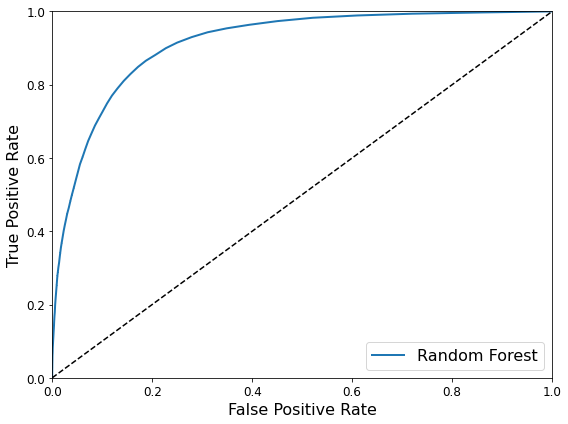

In [60]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

### Evaluating model on validation set

#### Transform validation data

In [61]:
X_val_tr = full_pipeline.transform(X_val)

#### Cross validation on validation set

In [62]:
cross_val_score(sgd_clf, X_val_tr, y_val, cv=3, scoring="accuracy")

array([0.86062762, 0.87574641, 0.88043202])

#### Validation set Confusion matrix

In [63]:
y_val_pred = cross_val_predict(sgd_clf, X_val_tr, y_val, cv=3)
confusion_matrix(y_val, y_val_pred)

array([[20137,   685],
       [ 2331,   459]], dtype=int64)

#### Validation set Precision score

In [64]:
precision_score(y_val, y_val_pred)

0.4012237762237762

#### Validation set recall score

In [65]:
recall_score(y_val, y_val_pred)

0.16451612903225807

#### Validation set F1 score

In [66]:
f1_score(y_val, y_val_pred)

0.2333502796136248

In [67]:
y_scores = cross_val_predict(sgd_clf, X_val_tr, y_val, cv=3,
                             method="decision_function")

#### Precision Recall curve

In [68]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores)

#### Plot precision recall vs threshold

Saving figure precision_recall_vs_threshold_plot


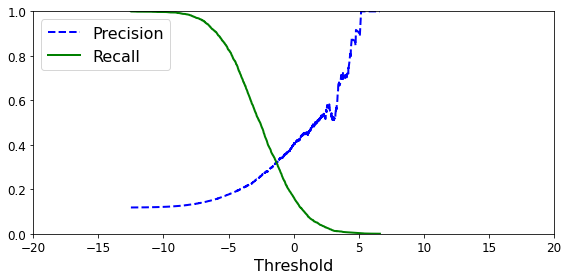

In [69]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-20, 20])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

In [70]:
y_scores

array([-7.21764919, -8.14789011, -4.25510259, ..., -7.39079059,
       -6.73555842, -6.44229187])

In [71]:
y_val_pred_40 = (y_scores > -5)

In [72]:
precision_score(y_val, y_val_pred_40)

0.17644359464627152

In [73]:
recall_score(y_val, y_val_pred_40)

0.8268817204301075

#### ROC curves

In [74]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_scores)

Saving figure roc_curve_plot


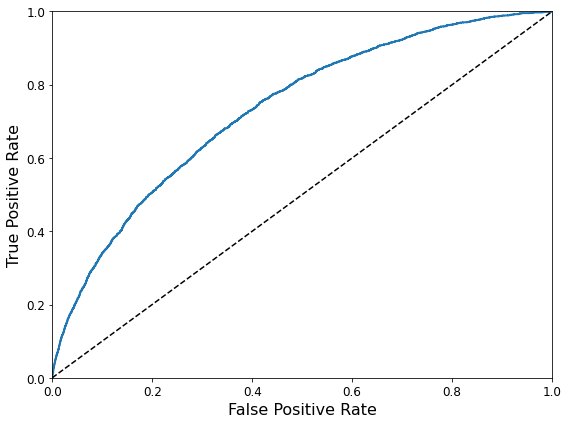

In [75]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

#### AUC score

In [76]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, y_scores)

0.7325789788784884

In [77]:
y_probas_forest = cross_val_predict(forest_clf, X_val_tr, y_val, cv=3,
                                    method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_val,y_scores_forest)

Saving figure roc_curve_comparison_plot


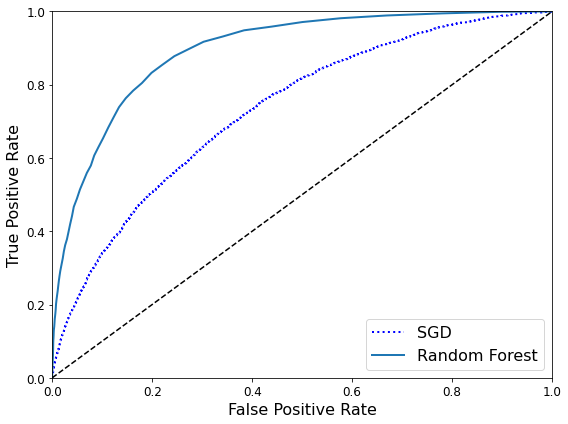

In [78]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

#### Random Forest is performing better than SGD classifier

#### Hyperparameter tuning Random Forest

In [79]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {  'bootstrap': [True], 'max_depth': [5, 10, 15, 20], 'max_features': ['auto', 'log2'], 'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15]}

# Call RandomizedSearchCV
random_search = RandomizedSearchCV(forest_clf, param_grid)

# Fit the model
random_search.fit(X_val_tr,y_val)

# Print best parameters
print(random_search.best_params_)

{'n_estimators': 7, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}


# Final Model with Best hyperparameters for Random Forest

In [80]:
final_train_data = pd.concat([X_train, X_val])
final_labels = pd.concat([y_train, y_val])

In [81]:
final_train_data_tr = full_pipeline.transform(final_train_data)

In [82]:
final_forest_clf = RandomForestClassifier(n_estimators=13, max_features='auto', max_depth=20, bootstrap=True, random_state=42)
y_probas_forest = cross_val_predict(final_forest_clf, final_train_data_tr, final_labels, cv=3,
                                    method="predict_proba")

### Transform unseen test set

In [83]:
X_test_tr = full_pipeline.transform(X_test)

In [84]:
y_probas_forest = cross_val_predict(final_forest_clf, X_test_tr, y_test, cv=3,
                                    method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test,y_scores_forest)

Saving figure roc_curve_comparison_plot


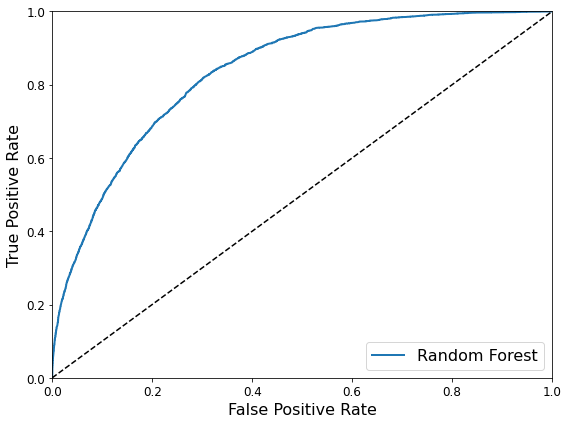

In [85]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

#### Test set confusion matrix

In [86]:
y_test_pred = cross_val_predict(final_forest_clf, X_test_tr, y_test, cv=3)
confusion_matrix(y_test, y_test_pred)

array([[32726,     9],
       [ 4339,    61]], dtype=int64)

#### Precision score

In [87]:
precision_score(y_test, y_test_pred)

0.8714285714285714

In [88]:
recall_score(y_test, y_test_pred)

0.013863636363636364

### F1 score

In [89]:
f1_score(y_test, y_test_pred)

0.02729306487695749

#### Precision is high over here, we can adjust the threshold to maintain precision - recall tradeoff

In [90]:
# save the model to disk
filename = 'finalized_model.sav'
joblib.dump(final_forest_clf, filename)

['finalized_model.sav']